In [307]:
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [308]:
df = pd.read_csv("../ai/data/housing_az_sqm_azn.csv")

In [309]:
df.head()

,PriceAZN,Bedrooms,Bathrooms,Sqm,City
0,225000,1,1,87.9,Baku
1,53200,3,2,45.0,Sumqayit
2,224100,3,2,81.2,Baku
3,318500,4,1,120.6,Baku
4,148900,5,1,126.9,Ganja


In [310]:
target_column = "PriceAZN"
X = df.drop(columns=[target_column])
y = df.iloc[:, 0]

In [311]:
X.head()

,Bedrooms,Bathrooms,Sqm,City
0,1,1,87.9,Baku
1,3,2,45.0,Sumqayit
2,3,2,81.2,Baku
3,4,1,120.6,Baku
4,5,1,126.9,Ganja


In [312]:
y.head()

0    225000
1     53200
2    224100
3    318500
4    148900
Name: PriceAZN, dtype: int64

In [313]:
X.isna().sum()

Bedrooms     0
Bathrooms    0
Sqm          0
City         0
dtype: int64

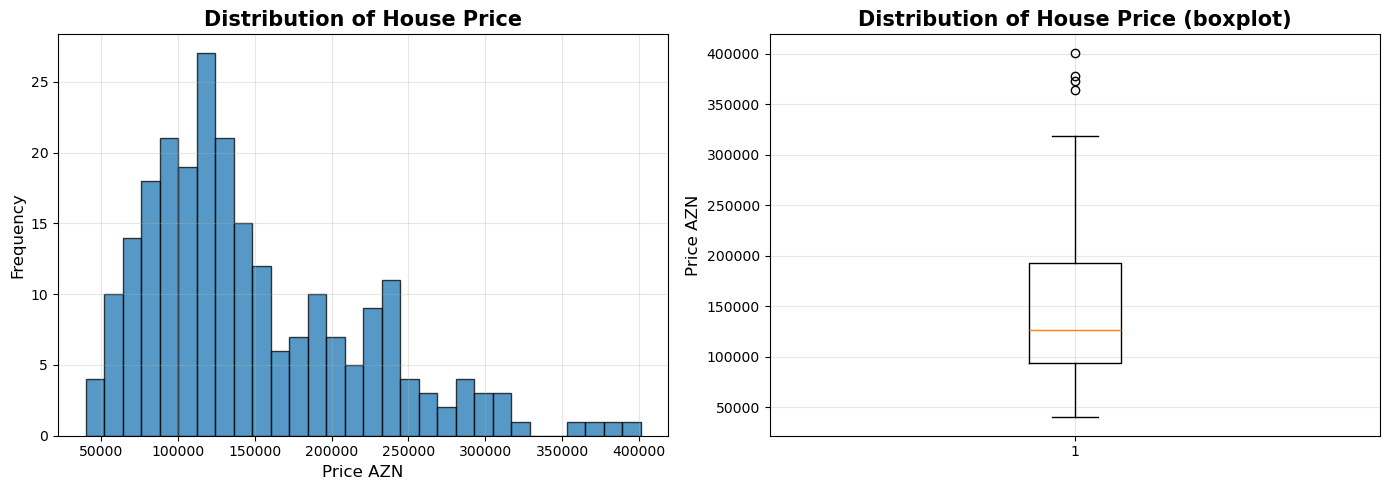

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=30, edgecolor='k', alpha=0.75)
axes[0].set_title('Distribution of House Price', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Price AZN', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(y, vert=True)
axes[1].set_title('Distribution of House Price (boxplot)', fontsize=15, fontweight='bold')
axes[1].set_ylabel('Price AZN', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [315]:
y.describe()


count       240.000000
mean     147927.083333
std       71134.645560
min       40000.000000
25%       94400.000000
50%      126950.000000
75%      192525.000000
max      401100.000000
Name: PriceAZN, dtype: float64

In [316]:
X.describe()

,Bedrooms,Bathrooms,Sqm
count,240.000000,240.00000,240.000000
mean,2.908333,2.01250,92.547917
std,1.420094,0.82066,27.146753
min,1.000000,1.00000,45.000000
25%,2.000000,1.00000,72.200000
50%,3.000000,2.00000,92.750000
75%,4.000000,3.00000,110.700000
max,5.000000,3.00000,171.100000


In [317]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


In [318]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gbr', gbr)
])


In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [320]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('gbr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [321]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"{mae:.2f}")
print(f"{rmse:.2f}")
print(f"{r2:.2f}")

14224.66
18839.91
0.92


In [322]:
test_predictions = pd.DataFrame({
    "Bedrooms": [2],
    "Bathrooms": [3],
    "Sqm": [56],
    "City": ["Baku"]
})

prediction = pipeline.predict(test_predictions)[0]
print(f"{prediction:.2f}")


141143.35


In [323]:
bundle = {
    "Pipeline": pipeline,
    "featured_order": ["Bedrooms", "Bathrooms", "Sqm", "City"]
}

model_path = Path("../ai/model/model.pkl")
model_path.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(bundle, model_path)


['..\\ai\\model\\model.pkl']